# Algorithm to make city urban master plan 
## Description
### Input data
Input - GeoJSON file with main objects, restrictions and areas for buildings
The program must do next:
1. Plot boundaries – transmitted in GeoJSON format (FeatureCollection with Polygon).
2. Take into account restrictions on building density – percentage of the plot area allowed for development.
3. Take into account minimum distance between objects – for example, 10 meters between buildings.
4. Additional restrictions – presence of roads, forests, water bodies on which construction is prohibited (also transmitted in GeoJSON).
### Algorithm tasks
1. Divide the site into logical zones (e.g. residential buildings, parks, roads).
2. Place objects (buildings, roads, green areas) taking into account the specified restrictions, excluding construction in prohibited zones (roads, forests, water bodies).
3. Generate an image of the site plan.
5. Create a GeoJSON file with the coordinates of the placed objects.



In [72]:
import json
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union,nearest_points

import shapely
import numpy as np
import geopandas as gpd
import pandas as pd
import utils_func
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# filenames
INPUT_FILE_NAME = "geo_data_2.json"

INPUT_FOLDER = "data"
OUTPUT_FOLDER = "output"

# 
INPUT_FILE = Path(INPUT_FOLDER) / INPUT_FILE_NAME
OUTPUT_FILE_NAME=Path(OUTPUT_FOLDER) /(Path(INPUT_FILE_NAME).stem + "_output")
OUTPUT_FILE_JSON = OUTPUT_FILE_NAME.with_suffix(".json")
OUTPUT_FILE_MAP = OUTPUT_FILE_NAME.with_suffix(".png")
OUTPUT_FILE_REPORT = OUTPUT_FILE_NAME.with_suffix(".html")
print(OUTPUT_FILE_NAME)

output\geo_data_2_output


In [74]:
# Additional constraints
MAX_BUILDING_DENSITY = 0.4  # 40% maximum building density
MIN_DISTANCE = 75  # m - distance between houses
HOUSE_WIDTH=150 # m
HOUSE_LENGTH=200 # m
BUILDING_SIZE = HOUSE_WIDTH*HOUSE_LENGTH  # m2
BUFFER_DIST = 15 # m - distance from boundaries and the closest restrictions
ROAD_MIN_WIDTH = 2 # m 
NTREES_PER_100M2= 1 # number of trees per 100m2
N_TREES_MAX=20 # max number of trees in each zone
N_HOUSES_MAX=80 # max number of houses in each zone

In [75]:
geojson_data = json.load(open(INPUT_FILE))
gdf_wgs84=gpd.GeoDataFrame.from_features(geojson_data['features'],crs="EPSG:4326")
print(gdf_wgs84.head())


                                            geometry            name  \
0  POLYGON ((-74.02 40.7, -73.99 40.7, -73.99 40....  Зона застройки   
1  POLYGON ((-74.01 40.71, -74.005 40.71, -74.005...     Лесная зона   
2        LINESTRING (-74.018 40.705, -73.992 40.705)          Дорога   

  restriction  
0         NaN  
1    no_build  
2    no_build  


Before - project coordinates to local meters system for simplifying further analyze.
After analyze and design the result would be exported to original coordinate system

In [76]:
# Project to UTM Zone 37N (meters)
gdf_utm = gdf_wgs84.to_crs(epsg=32637)
print(gdf_utm)

                                            geometry            name  \
0  POLYGON ((-5007597.498 12718340.41, -5009521.8...  Зона застройки   
1  POLYGON ((-5006940.112 12716509.035, -5007260....     Лесная зона   
2  LINESTRING (-5007076.432 12717721.188, -500874...          Дорога   

  restriction  
0         NaN  
1    no_build  
2    no_build  


Local bounds: [   0.            0.         4261.94656486 4482.39024274]


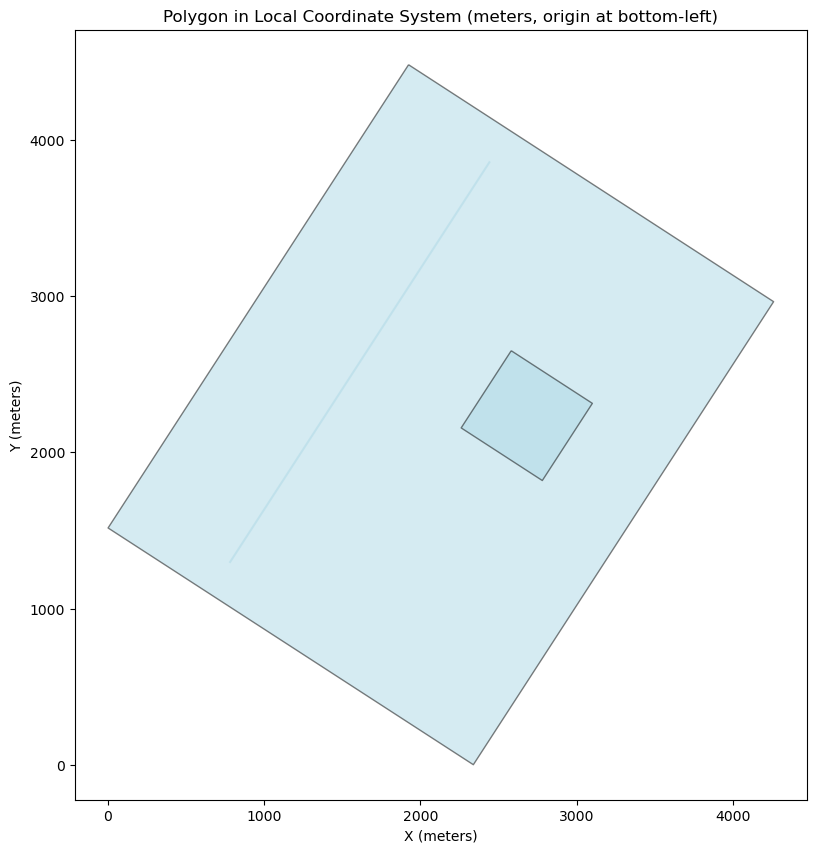

Back to WGS84 bounds: [-74.02   40.7   -73.99   40.718]


In [77]:
#  for simplicity translate to local coordinate system
# Step: Get the bounding box and shift to local coordinates
bounds_utm = gdf_utm.total_bounds  # [minx, miny, maxx, maxy]
x_min, y_min = bounds_utm[0], bounds_utm[1]

# Define a function to shift coordinates
def shift_to_local(geom, x_offset, y_offset):
    geom1=shapely.affinity.translate(geom,xoff=-x_offset, yoff=-y_offset)
    return geom1

# Apply shift to set bottom-left corner as (0, 0)
gdf_local = gdf_utm.copy()
gdf_local["geometry"] = gdf_utm["geometry"].apply(shift_to_local, args=(x_min, y_min))

# Since this is a custom local system, CRS is no longer strictly UTM; set to None or custom
gdf_local.crs = None  # Or define a custom CRS if needed

# Verify bounds
print("Local bounds:", gdf_local.total_bounds)  # Should start at (0, 0)

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
gdf_local.plot(ax=ax, color="lightblue", alpha=0.5, edgecolor="black")
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
plt.title("Polygon in Local Coordinate System (meters, origin at bottom-left)")
plt.show()

# Optional: Convert back to WGS84 if needed
gdf_local_shifted = gdf_local.copy()
gdf_local_shifted["geometry"] = gdf_local["geometry"].apply(shift_to_local, args=(-x_min, -y_min))
gdf_local_shifted.crs = "EPSG:32637"
gdf_wgs84_back = gdf_local_shifted.to_crs("EPSG:4326")
print("Back to WGS84 bounds:", gdf_wgs84_back.total_bounds)

In [78]:
# for all lines (roads) set minimum width to regard them like object polygons

linestrings = gdf_local[gdf_local.geometry.geom_type == 'LineString']

# Apply buffer  to the LineString geometries
gdf_local.loc[gdf_local.geometry.geom_type == 'LineString', 'geometry'] = linestrings.geometry.buffer(ROAD_MIN_WIDTH)
# Print the updated GeoDataFrame
print(gdf_local)

                                            geometry            name  \
0  POLYGON ((1924.32 4482.39, 0 1516.058, 2339.12...  Зона застройки   
1  POLYGON ((2581.706 2651.015, 2261.103 2156.767...     Лесная зона   
2  POLYGON ((779.68 1291.557, 779.565 1291.397, 7...          Дорога   

  restriction  
0         NaN  
1    no_build  
2    no_build  


(<matplotlib.patches.PathPatch at 0x2922cab7110>,
 <matplotlib.lines.Line2D at 0x2922cab7250>)

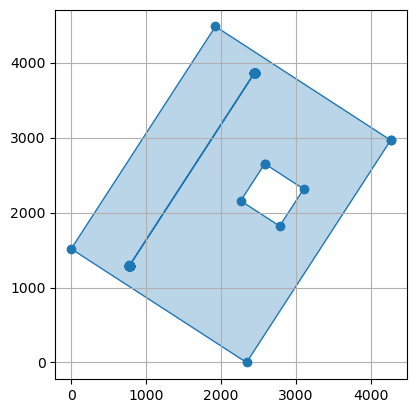

In [79]:
# Define valid and non valid build zones
# Calculate the union of all zones
all_zone=unary_union(gdf_local['geometry'])
no_build_zones = unary_union(gdf_local[gdf_local['restriction'] == "no_build"]['geometry'])
build_zones = unary_union(gdf_local[gdf_local['restriction'] != "no_build"]['geometry'])
valid_build_zone0=build_zones.difference(no_build_zones)
shapely.plotting.plot_polygon(valid_build_zone0)

Text(0.5, 1.0, 'Valid build zone with obstacles')

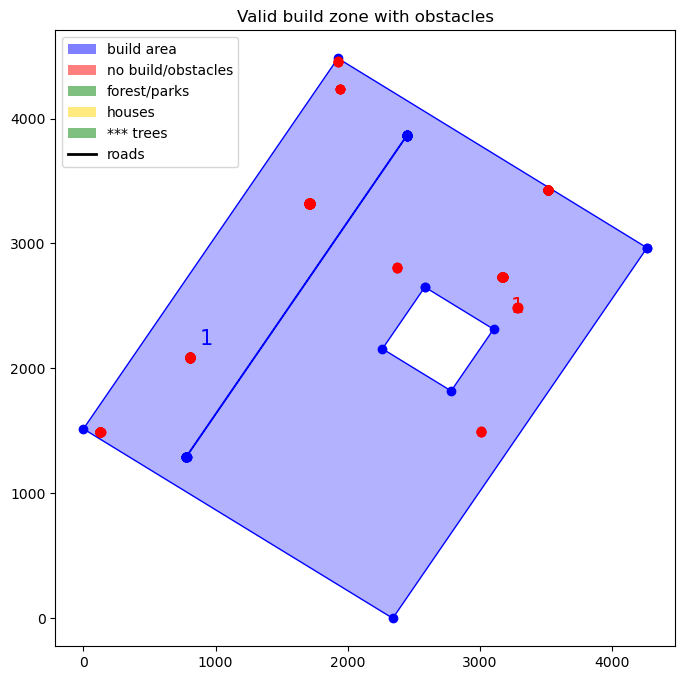

In [80]:
# To make task more interesting - randomly add syntetic obstacles into valid_build_zone
obstacles=utils_func.place_obstacles(valid_build_zone0,10,max_radius=2,max_side=4)

utils_func.plot_zones(valid_build_zone0,no_build_zones=obstacles)
plt.title("Valid build zone with obstacles")

(<Figure size 800x800 with 1 Axes>, <Axes: >)

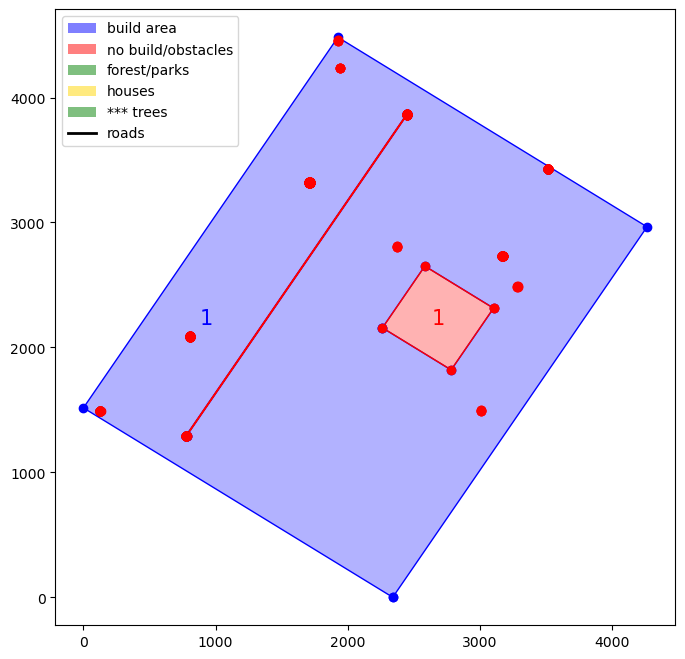

In [81]:
#  update zones unions with new objects
no_build_zones1=unary_union([no_build_zones,obstacles])
valid_build_zone1=valid_build_zone0.difference(no_build_zones)
utils_func.plot_zones(valid_build_zone1,no_build_zones1)

Separate territory into zones for buildings, roads and park
For separation Voronoi diagram would be used

In [82]:
# estimate area for buildings
import math
max_build_area = valid_build_zone0.area * MAX_BUILDING_DENSITY
house_rad=np.sqrt(BUILDING_SIZE / np.pi)
required_radius = house_rad + MIN_DISTANCE
house_zone_area = np.pi * required_radius ** 2
n_houses_max= math.ceil(max_build_area/house_zone_area)
print(f"max_build_area:{max_build_area:.2f}")
print(f"required_radius:{required_radius:.2f}")
print(f"house_zone_area:{house_zone_area:.2f}")
print(f"n_houses_max:{n_houses_max}")


max_build_area:3790109.63
required_radius:172.72
house_zone_area:93721.16
n_houses_max:41


[<MULTIPOLYGON (((1341.387 2361.283, 1418.263 2283.379, 982.388 1611.411, 56....>, <MULTIPOLYGON (((1421.14 2280.463, 1468.335 2353.223, 2150.447 2309.915, 219...>, <POLYGON ((2060.188 1197.603, 2156.405 1401.606, 2761.442 1683.452, 2694.013...>, <POLYGON ((982.388 1611.411, 776.324 1293.733, 776.226 1293.564, 776.144 129...>, <POLYGON ((2060.188 1197.603, 1410.441 1614.921, 1854.042 1841.773, 1915.764...>, <MULTIPOLYGON (((1759.264 3832.572, 1947.61 3099.446, 1463.756 2353.513, 134...>, <POLYGON ((1915.764 1815.545, 2196.351 2265.164, 2326.828 2258.091, 2261.103...>, <MULTIPOLYGON (((1948.962 3094.181, 2186.058 3459.701, 3594.656 2229.073, 35...>, <POLYGON ((2761.442 1683.452, 3500.869 2194.44, 3594.656 2229.073, 3772.57 2...>, <POLYGON ((3594.656 2229.073, 2186.058 3459.701, 2447.064 3862.079, 2447.162...>]


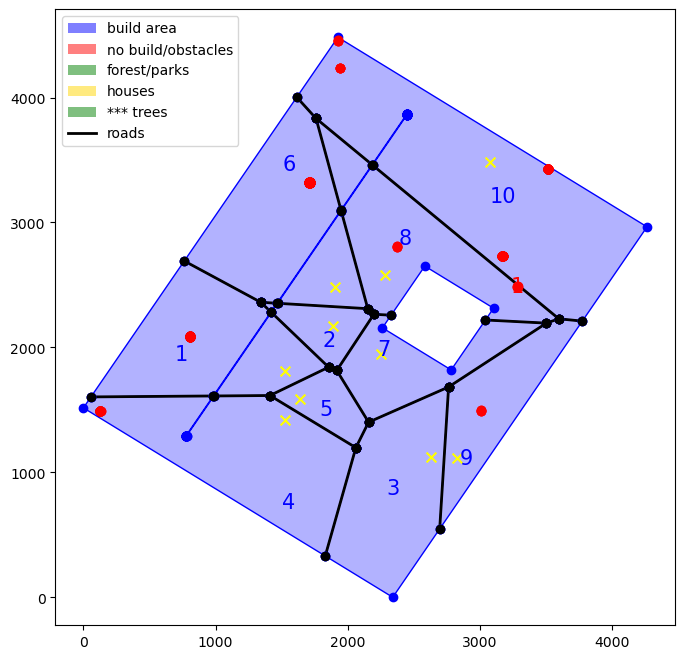

In [83]:
# separate into zones 
vbz=valid_build_zone1
# number of zones - to have 3-5 houses in each zone in mean +1 zone for park
n_regions=min([math.ceil(n_houses_max/5)+1,10])
seed_points,build_zones,vor,vor_edges = utils_func.separate_voronoi(vbz,n_regions)
roads=vor_edges
utils_func.plot_zones(build_zones=build_zones,no_build_zones=obstacles,roads=roads)
plt.scatter(seed_points[:, 0], seed_points[:, 1], s=50,c='yellow',marker='x')
print(build_zones)

[[0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.]]
[3. 3. 5. 2. 4. 4. 5. 4. 2. 5. 5. 2. 4. 4.]


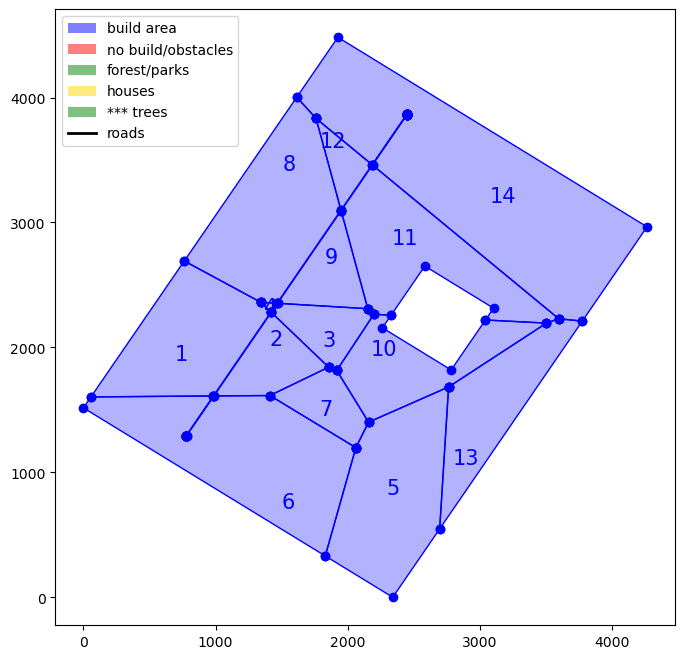

In [84]:
# in case of multipolygon try to merge some zones
if any([zone.geom_type=='MultiPolygon' for zone in build_zones]):
    build_zones=utils_func.combine_zones(build_zones)
    utils_func.plot_zones(build_zones)

In [85]:
#  process roads for case multilinestring and empty 
roads1=[]
for road in roads:
    if road.is_empty:
        continue
    if road.geom_type in ['MultiLineString']:
        p1=road.geoms[0].coords[0]
        p2=road.geoms[-1].coords[1]
        road_new=shapely.LineString((p1,p2))
        roads1.append(road_new)
        # for geom in road.geoms:
        #     roads1.append(geom)
    else:
        roads1.append(road)
        
print(roads1)
    

[<LINESTRING (762.773 2691.87, 1341.387 2361.283)>, <LINESTRING (1341.387 2361.283, 1854.042 1841.773)>, <LINESTRING (1854.042 1841.773, 1410.441 1614.921)>, <LINESTRING (1410.441 1614.921, 56.936 1603.824)>, <LINESTRING (1341.387 2361.283, 2150.447 2309.915)>, <LINESTRING (2150.447 2309.915, 2196.351 2265.164)>, <LINESTRING (2196.351 2265.164, 1915.764 1815.545)>, <LINESTRING (1915.764 1815.545, 1854.042 1841.773)>, <LINESTRING (1828.714 330.812, 2060.188 1197.603)>, <LINESTRING (2060.188 1197.603, 2156.405 1401.606)>, <LINESTRING (2156.405 1401.606, 2761.442 1683.452)>, <LINESTRING (2761.442 1683.452, 2694.013 547.259)>, <LINESTRING (1410.441 1614.921, 2060.188 1197.603)>, <LINESTRING (1915.764 1815.545, 2156.405 1401.606)>, <LINESTRING (1613.224 4002.837, 1759.264 3832.572)>, <LINESTRING (1759.264 3832.572, 2150.447 2309.915)>, <LINESTRING (2196.351 2265.164, 3500.869 2194.44)>, <LINESTRING (3500.869 2194.44, 2761.442 1683.452)>, <LINESTRING (1759.264 3832.572, 3594.656 2229.073)>, 

(<Figure size 800x800 with 1 Axes>, <Axes: >)

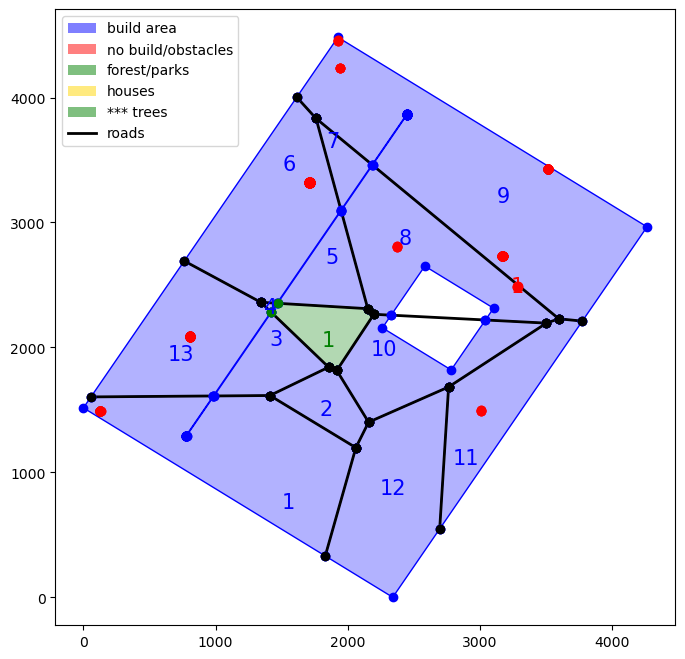

In [86]:
# select zone for park
# park -  central, is the only one zone that has the smallest dist to all other zones. centroids would be used
# + check area for buildings - should be enough for all
build_zones1=build_zones.copy()
n_regions=len(build_zones1)
zones_dist=np.zeros((n_regions,n_regions))
for id1,zone1 in enumerate(build_zones1):
    for id2,zone2 in enumerate(build_zones1):
        zones_dist[id1,id2]=zone1.centroid.distance(zone2.centroid)
zone_park_idx=zones_dist.sum(axis=0).argmin()

park_zone=build_zones1.pop(zone_park_idx)
build_zones1 = utils_func.nearest_neighbor_sort(build_zones1)
utils_func.plot_zones(build_zones1,obstacles,park_zone,roads=roads1)

In [87]:
#  check is area enough for building
zones_area=np.array([zone.area for zone in build_zones])
area_for_buildings=zones_area.sum()
is_area_enough=area_for_buildings>=max_build_area
print(f"area for buildings except parks: {area_for_buildings}, \nis it enough (>{max_build_area})?: {is_area_enough}")


area for buildings except parks: 9475274.076466002, 
is it enough (>3790109.6305864016)?: True


now lest add some syntetic obstacles in the middle of the road and try to optimize the path to go around it + take into account other obstacles we had before

road 0: (762.7733654775506, 2691.8700569459347) - (1341.3867675045192, 2361.2827081492187)
road constructed in 3 parts
road 1: (1341.3867675045192, 2361.2827081492187) - (1854.0422912165575, 1841.7730211657129)
road constructed in 4 parts
road 2: (1854.0422912165575, 1841.7730211657129) - (1410.440876568108, 1614.920854492154)
road constructed in 2 parts
road 3: (1410.440876568108, 1614.920854492154) - (56.93590951113703, 1603.8240170119484)
road constructed in 3 parts
road 4: (1341.3867675045192, 2361.2827081492187) - (2150.446737014106, 2309.915278019842)
road constructed in 4 parts
road 5: (2150.446737014106, 2309.915278019842) - (2196.350626325381, 2265.1643870112885)
road constructed in 2 parts
road 6: (2196.350626325381, 2265.1643870112885) - (1915.7637562177395, 1815.5454942697563)
road constructed in 2 parts
road 7: (1915.7637562177395, 1815.5454942697563) - (1854.0422912165575, 1841.7730211657129)
road constructed in 2 parts
road 8: (1828.7144415884447, 330.8115146138008) - (2

(<Figure size 800x800 with 1 Axes>, <Axes: >)

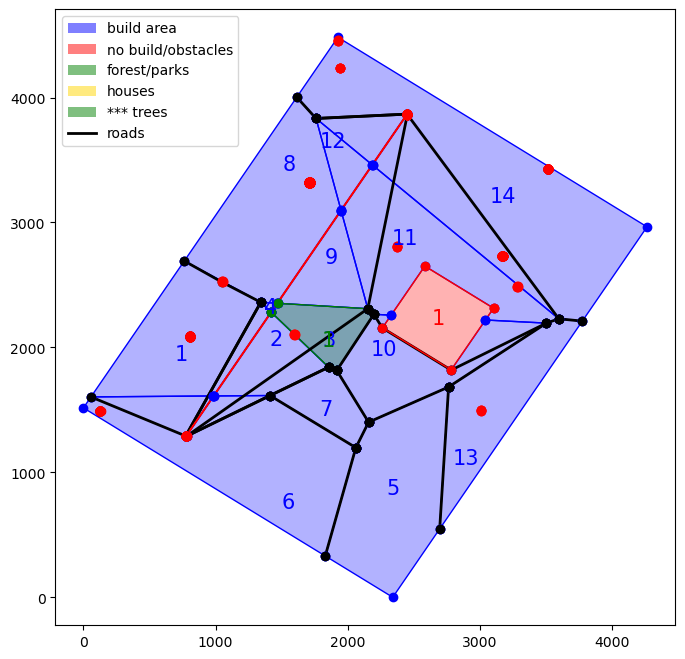

In [88]:
roads2=roads1.copy()
# # prepare restriction zones taken with buffer
# no_build_zones2=shapely.unary_union([valid_build_zone1.buffer(-0.5).exterior,no_build_zones1])
no_build_zones2=shapely.unary_union(no_build_zones1)
no_build_zones2=[zone for zone in no_build_zones2.geoms]

# # add syntetic obstacles to test algorithm
# # road=roads[1]
obstacle1= roads2[0].interpolate(roads2[0].length/2).buffer(3).minimum_rotated_rectangle
obstacle2= roads2[1].interpolate(roads2[1].length/2).buffer(3).minimum_rotated_rectangle
new_obstacles_on_road=[obstacle1,obstacle2]
no_build_zones2.append(obstacle1)
no_build_zones2.append(obstacle2)
no_build_zones2=shapely.unary_union(no_build_zones2)

for i,road in enumerate(roads2):
    print(f"road {i}: {road.coords[0]} - {road.coords[1]}")
    roads2[i]=utils_func.build_road_around_obstacles(Point(road.coords[0]), Point(road.coords[1]), no_build_zones2,buffer=1)
utils_func.plot_zones(build_zones,no_build_zones2,park_zone,roads2)


                                             geometry  \
0   POLYGON ((1924.32 4482.39, 0 1516.058, 2339.12...   
1   POLYGON ((2581.706 2651.015, 2261.103 2156.767...   
2   POLYGON ((779.68 1291.557, 779.565 1291.397, 7...   
0   MULTIPOLYGON (((1924.736 4455.942, 1926.077 44...   
0   POLYGON ((1341.387 2361.283, 1418.263 2283.379...   
1   POLYGON ((1854.042 1841.773, 1410.441 1614.921...   
2   POLYGON ((1421.14 2280.463, 1468.335 2353.223,...   
3   POLYGON ((1341.387 2361.283, 1463.756 2353.513...   
4   POLYGON ((2060.188 1197.603, 2156.405 1401.606...   
5   POLYGON ((982.388 1611.411, 776.324 1293.733, ...   
6   POLYGON ((2060.188 1197.603, 1410.441 1614.921...   
7   POLYGON ((1759.264 3832.572, 1947.61 3099.446,...   
8   POLYGON ((2150.447 2309.915, 1468.335 2353.223...   
9   POLYGON ((1915.764 1815.545, 2196.351 2265.164...   
10  POLYGON ((1948.962 3094.181, 2186.058 3459.701...   
11  POLYGON ((1759.264 3832.572, 2183.015 3462.359...   
12  POLYGON ((2761.442 1683.452

<Axes: >

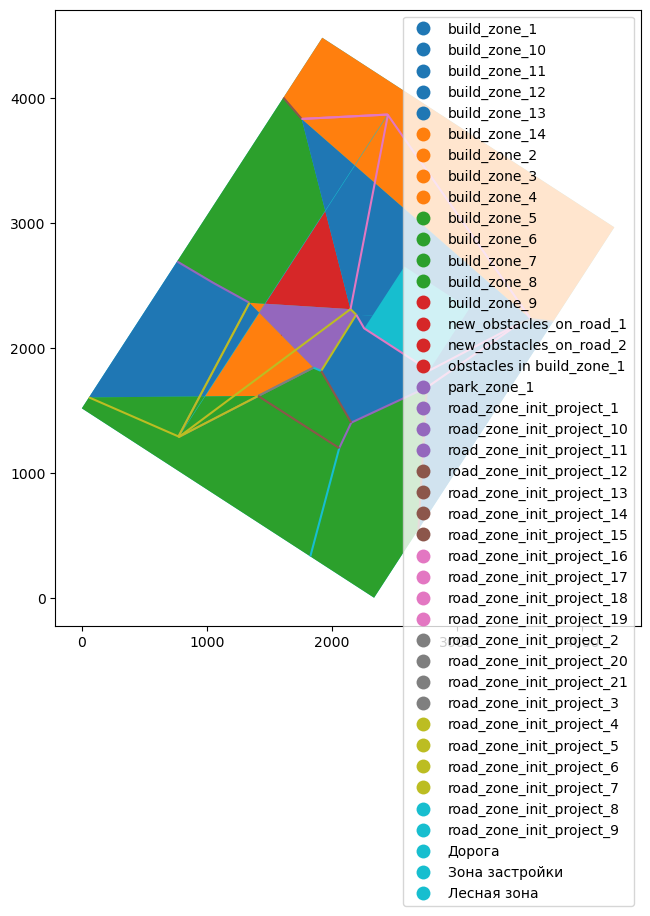

In [89]:
# store  intermediate results into dataframe
gdf_local1=gdf_local.copy()
gdf_local1=utils_func.gdf_append(gdf_local1,[obstacles],'obstacles in build_zone')
gdf_local1=utils_func.gdf_append(gdf_local1,build_zones,'build_zone','build_ok')
gdf_local1=utils_func.gdf_append(gdf_local1,[park_zone],'park_zone','build_ok')
gdf_local1=utils_func.gdf_append(gdf_local1,roads2,'road_zone_init_project','build_not_yet')
gdf_local1=utils_func.gdf_append(gdf_local1,new_obstacles_on_road,'new_obstacles_on_road','no_build')
print(gdf_local1)
gdf_local1.plot(column='name', legend=True, figsize=(8, 8))

# Place objects into map - buildings, roads, green zones 
taking into account restrictions

(<Figure size 800x800 with 1 Axes>, <Axes: >)

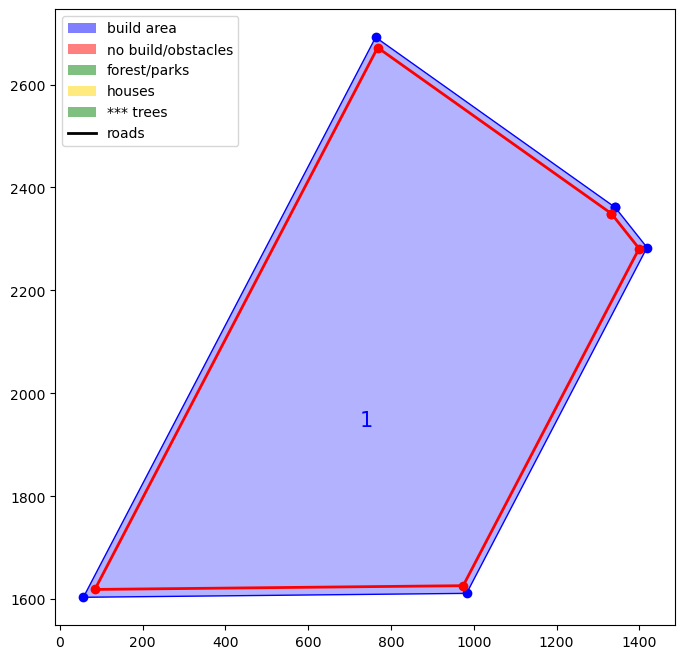

In [90]:
# each zone would have its own boundaries
zone=build_zones[0]
obst=zone.buffer(-1*BUFFER_DIST).exterior
utils_func.plot_zones(zone,obst)


zone 0
poly_area:1313707.28
house radius:97.72
poly_build_area:525482.91
center_zone_area:93721.16
estimated number of centers: 6
estimated number of houses: 18
number of generated centers on grid: 10
select that are far from restrictions
number of generated centers on grid: 26
select that are far from restrictions

zone 1
poly_area:227895.49
house radius:97.72
poly_build_area:91158.20
center_zone_area:93721.16
estimated number of centers: 1
estimated number of houses: 4
number of generated centers on grid: 1
number of generated centers on grid: 4
Could only place 4 of 20 centers due to space/restrictions

zone 2
poly_area:287234.47
house radius:97.72
poly_build_area:114893.79
center_zone_area:93721.16
estimated number of centers: 2
estimated number of houses: 4
number of generated centers on grid: 1
Could only place 1 of 2 centers due to space/restrictions
number of generated centers on grid: 5
Could only place 5 of 20 centers due to space/restrictions

zone 3
poly_area:4467.90
house

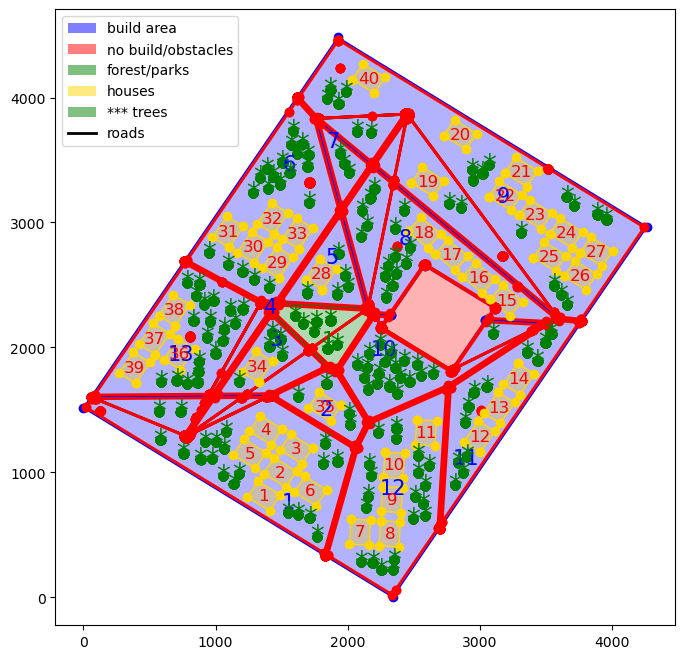

In [91]:
# give some space from borders
LOG_LEVEL = 1
vbz_border_margin=valid_build_zone1.buffer(-1*BUFFER_DIST).exterior
for zone in build_zones:
    zone_buffered=zone.buffer(-1*BUFFER_DIST)
    if zone_buffered.geom_type=='MultiPolygon':
        for geom in zone_buffered.geoms:
            vbz_border_margin=vbz_border_margin.union(geom.exterior)
    else:
        vbz_border_margin=vbz_border_margin.union(zone_buffered.exterior)
        
# add roads to restrictions
for road in roads2:
    vbz_border_margin=vbz_border_margin.union(road.buffer(1).exterior)
    
restricted_area1 = unary_union([no_build_zones1,vbz_border_margin])
houses_areas=[]
zone_trees=[]
build_zone_houses=[None]*len(build_zones1)

for i, zone in enumerate(build_zones1):
    print(f"\nzone {i}")
    
    poly_area = zone.area
    poly_build_area=poly_area*MAX_BUILDING_DENSITY
    house_rad=np.sqrt(BUILDING_SIZE / np.pi)
    required_radius = house_rad + MIN_DISTANCE
    center_zone_area = np.pi * required_radius ** 2
    n_centers= math.ceil(poly_build_area/center_zone_area)
    n_houses=math.ceil(poly_build_area/BUILDING_SIZE)
    if LOG_LEVEL:
        print(f"poly_area:{poly_area:.2f}")
        print(f"house radius:{house_rad:.2f}")
        print(f"poly_build_area:{poly_build_area:.2f}")
        print(f"center_zone_area:{center_zone_area:.2f}")
        print(f"estimated number of centers: {n_centers}")
        print(f"estimated number of houses: {n_houses}")

    n_centers = min([n_centers,N_HOUSES_MAX])

    centers = utils_func.place_objects(zone,restricted_area=restricted_area1, n_centers=n_centers, obj_length=HOUSE_LENGTH,  obj_width=HOUSE_WIDTH, buffer_distance=MIN_DISTANCE,randomly=False)

    build_zone_houses[i]=centers
    restricted_area_houses = restricted_area1
    
    if len(centers)>0:
        for center in centers:
            houses_areas.append(center)
            restricted_area_houses = unary_union([restricted_area_houses,center])
    
    n_trees=math.floor(poly_area/NTREES_PER_100M2)
    # place trees
    n_trees = min([n_trees,N_TREES_MAX])
    trees = utils_func.place_objects(zone,restricted_area=restricted_area_houses, n_centers=n_trees, obj_length=2,  obj_width=2, buffer_distance=MIN_DISTANCE,randomly=True)
    [zone_trees.append(tree) for tree in trees]

n_trees=math.floor(park_zone.area/NTREES_PER_100M2)

trees = utils_func.place_objects(park_zone,restricted_area=restricted_area_houses, n_centers=n_trees, obj_length=2,  obj_width=2, buffer_distance=MIN_DISTANCE,randomly=True)
[zone_trees.append(tree) for tree in trees]
#  sort houses as neighbours distance
houses_areas = utils_func.nearest_neighbor_sort(houses_areas)

fig,ax=utils_func.plot_zones(build_zones1,restricted_area1,park_zone,roads2,houses=houses_areas,trees=zone_trees)

better way to construct roads would be to use distance info to all obstacles and optimize on graph using A* (yet not done), example of distance map see below

# Save and export results

Map saved to output\geo_data_2_output.png


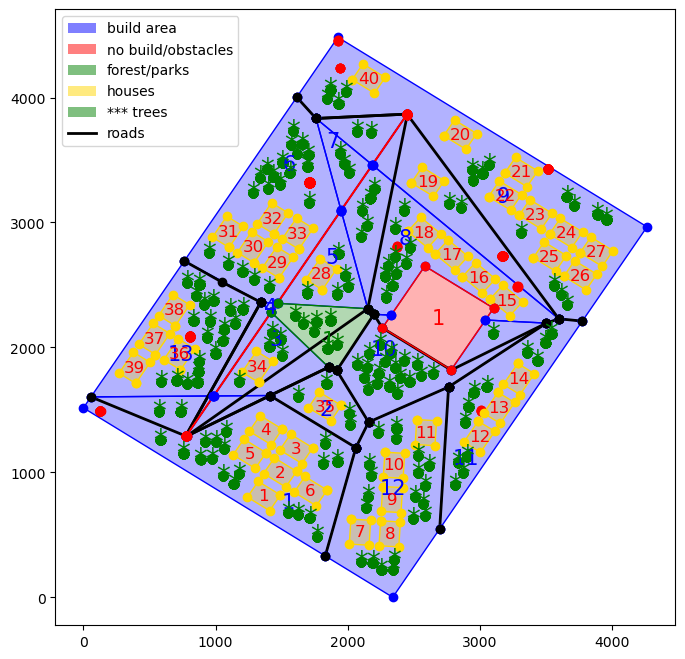

In [92]:
# final plot
fig,ax=utils_func.plot_zones(build_zones1,no_build_zones1,park_zone,roads2,houses=houses_areas,trees=zone_trees)

# export 
fig.savefig(OUTPUT_FILE_MAP)
print(f"Map saved to {OUTPUT_FILE_MAP}")

all coordinates are converted from local back to EPSG

In [93]:
#  update before export
#  export to geopandas
gdf_local2=gdf_local1.copy()
gdf_local2=utils_func.gdf_append(gdf_local2,houses_areas,'houses_areas','build_ok')
gdf_local2=utils_func.gdf_append(gdf_local2,trees,'trees','build_ok')
gdf_local2.crs = "EPSG:32637"
x_min, y_min = bounds_utm[0], bounds_utm[1]
gdf_local2["geometry"] = gdf_local2["geometry"].apply(shift_to_local, args=(-x_min, -y_min))
gdf_local2 = gdf_local2.to_crs("EPSG:4326")

# gdf_local2.plot(column='name', legend=True, figsize=(8, 8))
print(gdf_local2)
gdf_local2.to_file(OUTPUT_FILE_JSON, driver='GeoJSON')
print(f"Exported to {OUTPUT_FILE_JSON}")

                                             geometry  \
0   POLYGON ((-74.02 40.7, -73.99 40.7, -73.99 40....   
1   POLYGON ((-74.01 40.71, -74.005 40.71, -74.005...   
2   POLYGON ((-73.992 40.70501, -73.992 40.70501, ...   
0   MULTIPOLYGON (((-74.01981 40.7001, -74.01982 4...   
0   POLYGON ((-74.00221 40.7043, -74.00201 40.7049...   
..                                                ...   
2   POLYGON ((-74.00361 40.70768, -74.00361 40.707...   
3   POLYGON ((-74.00243 40.70864, -74.00243 40.708...   
4   POLYGON ((-74.00241 40.70732, -74.0024 40.7073...   
5   POLYGON ((-74.00246 40.70664, -74.00246 40.706...   
6   POLYGON ((-74.00188 40.70836, -74.00187 40.708...   

                         name restriction  
0              Зона застройки         NaN  
1                 Лесная зона    no_build  
2                      Дорога    no_build  
0   obstacles in build_zone_1    no_build  
0                build_zone_1    build_ok  
..                        ...         ...  
2      

In [94]:
print(f"Report saved to {OUTPUT_FILE_REPORT}")
!jupyter nbconvert --no-input --to html plan_prog.ipynb --output {OUTPUT_FILE_REPORT}

Report saved to output\geo_data_2_output.html


[NbConvertApp] Converting notebook plan_prog.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1738886 bytes to output\geo_data_2_output.html
